# Practical Session 3: Stochastic Approximation and Reinforcement Learning

##### *M2 Artificial Intelligence (Paris Saclay University) - Reinforcement Learning*

---

Machine Learning (ML) is a class of methods that aim at learning from observations and data, without relying on a model (e.g. based on physical laws). Reinforcement Learning is the subfield of ML that focuses on learning to make decisions in sequential decision-making problems.

Dynamic Programming (DP) methods, such as Value Iteration or Policy Iteration, require a complete model of the environment (concretely, the transition probabilities and reward function of the MDP).
However, in many real-world scenarios, such a model is not available. Instead, we can collect data by interacting with the decision process (a.k.a. environment or dynamics).

A theory called **Stochastic Approximation** provides tools to progressively estimate (learn) quantities of interest (e.g., value functions, optimal policies) from data collected online. The first part of this notebook aims at introducing the fundamentals concepts of this approach.

Reinforcement Learning algorithms arise as byproducts of the application of Stochastic Approximation to the Dynamic Programming equations.

--

Stochastic Approximation results are taken from *M. Duflo - "Random Iterative Models", Springer 1997*. A very good reference for their application to Reinforcement Learning is *J. Kwon - "An Introduction to Reinforcement Learning: From theory to algorithms, 2024"*.


<br>
<br>
<br>
<br>
<br>

## Part I: Stochastic Approximation

One important application of Stochastic Approximation is the estimation search of the solution of fixed-point equations or more generally root-finding problems.
First, the simple deterministic case is considered.

### Search for a Zero of a Continuous Function


**Theorem (Root-Finding):**

Suppose that $f$ is a continuous real function such that $f(x^*) = \alpha$ and such that, for all $x \neq x^*$:

$$(f(x) - \alpha)(x - x^*) < 0$$
$$|f(x)| \leq K(1 + |x|)$$

for some constant $K > 0$. Suppose that $(\gamma_n)$ is a positive sequence decreasing towards $0$ such that $\sum \gamma_n = \infty$ and that $(\varepsilon_n)$ is another sequence such that $\sum \gamma_n \varepsilon_{n+1} < \infty$ converges.

Then the sequence $(x_n)$ defined by:

$$x_{n+1} = x_n + \gamma_n(f(x_n) - \alpha + \varepsilon_{n+1})$$

converges to $x^*$, for all initial values $x_0$.


-- *Special Case (Deterministic Study)* --

For a deterministic study, we naturally take $\varepsilon_{n+1} = 0$. With the above assumptions on $f$, we may take $\gamma_n = \frac{1}{n}$. The update rule becomes:

$$x_{n+1} = x_n + \frac{1}{n}(f(x_n) - \alpha)$$


<div class="alert alert-warning">

#### Question: Loss Optimisation

Give the typical function $f$ used in machine learning to perform loss optimisation. What is the meaning of $x^*$ in this context? What is the usual value for $\alpha$ ?

</div>

<div class="alert alert-info">

#### Answer:

In machine learning, the typical function $f$ used for loss optimisation is the gradient of the loss function with respect to the model parameters. Specifically, if we denote the loss function as $L(x)$, then $f(x) = \nabla L(x)$.
Here, $x^*$ is a zero of the gradient function, which corresponds to a local minimum (or maximum) of the loss function. The value $\alpha$ is typically set to $0$, indicating that we are looking for points where the gradient is zero.

</div>

<div class="alert alert-warning">

#### Question: Finding the zero of a noisy function

Consider the function $f(x) = - \frac{x - 2}{1 + |x - 2|}$ and a deterministic noise defined by $\varepsilon_n = \sin(3n)$. The true root is $x^* = 2$ with $\alpha = 0$.

-  Show that the assumptions of the theorem are satisfied for this function with $\alpha = 0$.
-  Implement the root-finding algorithm to find the root of this function.
-  Run it for $N=20000$ iterations starting at $x_0 = -4$.
-  Use a learning rate decay of $\gamma_n = \frac{1}{n}$.
-  Plot the convergence of $x_n$ towards the true root.

</div>

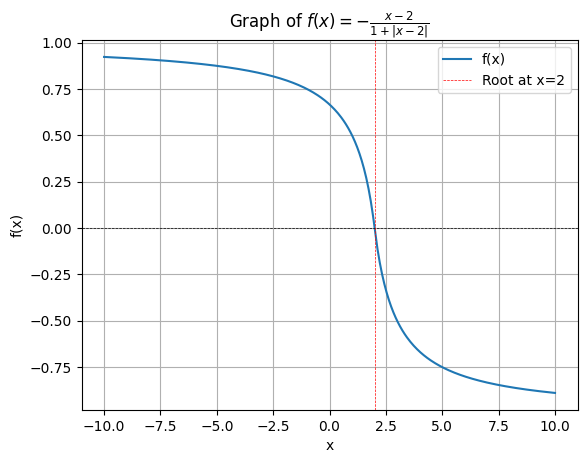

In [1]:
# Graph of f(x) = - (x - 2) / (1 + |x - 2|). Highlighted in red is the root at x = 2.
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 400)
f_x = - (x - 2) / (1 + np.abs(x - 2))
plt.plot(x, f_x, label='f(x)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(2, color='red', lw=0.5, ls='--', label='Root at x=2')
plt.title(r'Graph of $f(x) = - \frac{x - 2}{1 + |x - 2|}$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()


<div class="alert alert-info">

#### Answer:

**Verification of the sssumptions**

We consider the function $f(x) = - \frac{x - 2}{1 + |x - 2|}$ with target $x^* = 2$ and $\alpha=0$.

* **Sign condition:** We must verify that $(f(x) - \alpha)(x - x^*) < 0$ for all $x \neq x^*$.
    Substitute the function:
    $$\left( - \frac{x - 2}{1 + |x - 2|} \right) (x - 2) = - \frac{(x - 2)^2}{1 + |x - 2|}$$
    Since $(x-2)^2 > 0$ for all $x \neq 2$ and the denominator is always positive, the entire expression is strictly negative. The condition is satisfied.

* **Growth condition:** We must verify $|f(x)| \leq K(1 + |x|)$.
    $$|f(x)| = \left| - \frac{x - 2}{1 + |x - 2|} \right| = \frac{|x - 2|}{1 + |x - 2|} < 1$$
    The function is bounded by 1 everywhere. Since $1 \leq 1 \cdot (1 + |x|)$ for any $K \ge 1$, the linear growth condition is satisfied.

* **Step size & noise:**
    $\gamma_n = 1/n$ satisfies $\sum \gamma_n = \infty$.
    The noise term $\sum \gamma_n \varepsilon_{n+1} \approx \sum \frac{1}{n} \cdot \frac{\sin(3n)}{n} = \sum \frac{\sin(3n)}{n^2}$ converges absolutely since $\sum \frac{1}{n^2}$ converges and $| \sin(3n) | < 1$.

</div>

Scale 0: Final estimate = 1.9377
Scale 10: Final estimate = 1.6630


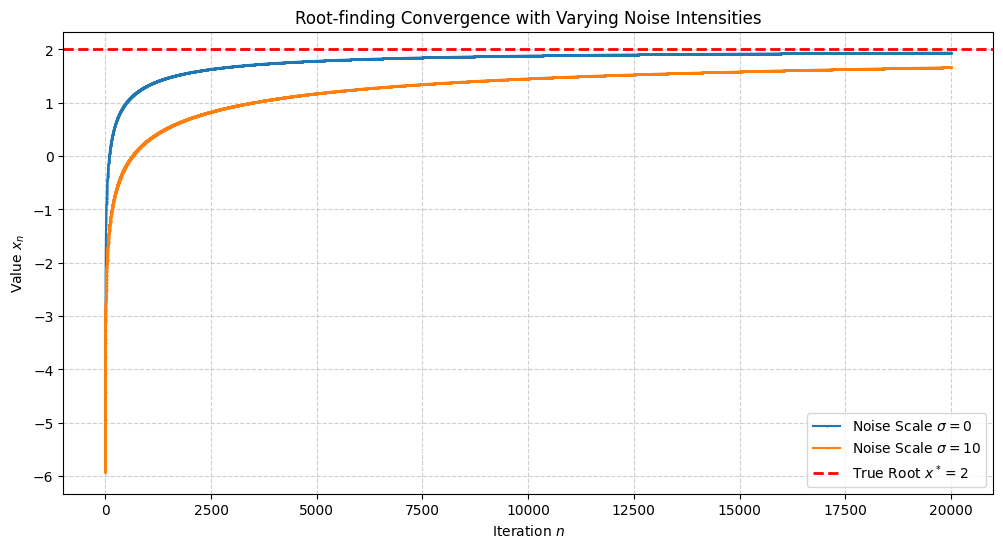

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f
def f(x):
    return - (x - 2) / (1 + np.abs(x - 2))

def get_noise(n, scale):
    # Deterministic noise scaled by intensity
    return scale * np.sin(3 * n)

# Parameters
x_star = 2.0
x_0 = -4.0   # Start at x_0 = -5
N = 20000
noise_scales = [0, 10]


# Loop over different noise scales
plt.figure(figsize=(12, 6))

for scale in noise_scales:
    x = x_0
    history = [x]
    
    # Root finding loop
    for n in range(1, N + 1):
        gamma_n = 1.0 / n
        
        # Scaled noise
        eps = get_noise(n + 1, scale)
        
        # Update Rule
        update = gamma_n * (f(x) + eps)
        x = x + update
        
        history.append(x)
    
    # Plot this run
    plt.plot(history, label=f'Noise Scale $\sigma={scale}$', marker='o', markersize=0.5)
    print(f"Scale {scale}: Final estimate = {x:.4f}")

# Final plot formatting
plt.axhline(y=x_star, color='r', linestyle='--', linewidth=2, label='True Root $x^* = 2$')
plt.xlabel('Iteration $n$')
plt.ylabel('Value $x_n$')
plt.title(r'Root-finding Convergence with Varying Noise Intensities')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

### Stochastic Approximation: the Robbins-Monro Algorithm

A generalisation of the above theorem to stochastic settings is provided by the Robbins-Monro algorithm. It is stated here for completeness.


**Theorem (Robbins-Monro, 1951)**:

Suppose that $(X_n)$ and $(Y_n)$ are two square-integrable sequences of random vectors adapted to a filtration $\mathbb{F} = (\mathcal{F}_n)_{n \geq 0}$ with values in $\mathbb{R}^d$.
Let $(\gamma_n)$ be a positive sequence decreasing towards zero of random variables adapted to $\mathbb{F}$, with $\gamma_0 \le \text{const.}$, such that the relation $X_{n+1} = X_n + \gamma_n Y_{n+1}$ holds.

Suppose further that:
$$E[Y_{n+1} \mid \mathcal{F}_n] = f(X_n) \quad \text{and} \quad E[\|Y_{n+1} - f(X_n)\|^2 \mid \mathcal{F}_n] = \sigma^2(X_n)$$

Then, suppose the function $f$ is continuous from $\mathbb{R}^d$ to $\mathbb{R}^d$ and zero at the point $x^*$ i.e. $f(x^*)=0$, and for $x \neq x^*$:
$$\langle f(x), x - x^* \rangle < 0$$
(For example, if $d=1$, $f$ is strictly decreasing).

We also assume one of the following conditions:
* **If $d=1$:** $|f(x)| \le K(1+|x|)$ for some constant $K$, and a.s. $\sum \gamma_n = \infty$, and $\sum \gamma_n^2 \sigma^2(X_n) < \infty$.
* **If $d>1$:** $\sigma^2(x) + \|f(x)\|^2 \le K(1+\|x\|^2)$ and a.s. $\sum \gamma_n = \infty$, and $\sum \gamma_n^2 < \infty$.

**Conclusion:**
Then $X_n \xrightarrow{a.s.} x^*$.

*Remark:* Often $(\gamma_n)$ is chosen deterministically, e.g., $\gamma_n = \frac{\gamma}{n}$ for $n \ge 1$.

<div class="alert alert-warning">

#### Question: A 2D Noisy Gradient Descent

Imagine a hiker trying to find the lowest point of a valley in thick fog. They can only measure the slope where they stand, but their measurements are noisy.
We model this as finding the minimum of an elliptical bowl function:
$$L(x, y) = \frac{1}{2}(x^2 + 10y^2)$$
The true minimum is at $(0,0)$. The gradient (slope) is $\nabla L = (x, 10y)^T$.
To find the minimum, we search for the zero of the negative gradient:
$$f(X) = -\nabla L(X) = - \begin{pmatrix} x \\ 10y \end{pmatrix}$$

At each step $n + 1$, we observe a noisy direction $Y_{n + 1} = f(X_n) + \varepsilon_n$, where $\varepsilon_n \sim \mathcal{N}(0, 4I)$ (Gaussian noise with $\sigma=2$).

-  Verify that the assumptions of the Robbins-Monro theorem are satisfied for this function.
-  What is the common name of this algorithm in machine learning?
-  Implement the Robbins-Monro algorithm for this 2D function.
-  Run the simulation for $N=1000$ iterations starting at $X_0 = (-4, 3)$.
-  Use a learning rate decay of $\gamma_n = \frac{1}{n}$.
-  Plot the trajectory of the agent $(x_n, y_n)$ on top of the contour plot of the loss function.

</div>

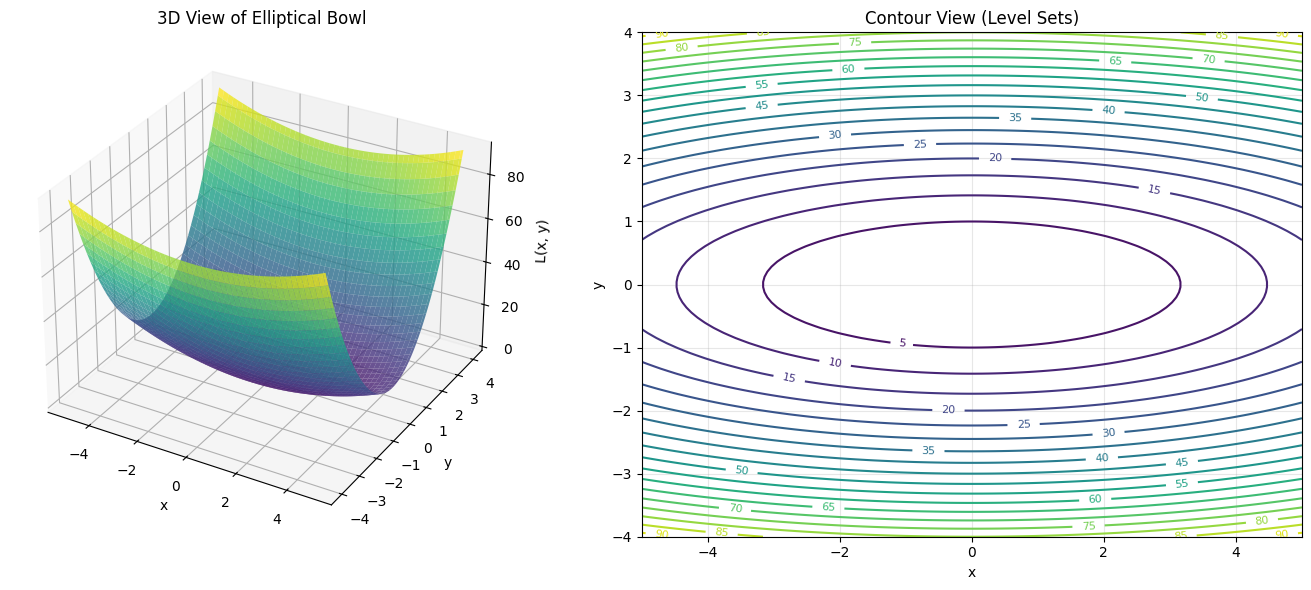

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the grid
x = np.linspace(-5, 5, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)

# Define the function: L(x,y) = 0.5 * (x^2 + 10y^2)
Z = 0.5 * (X**2 + 10 * Y**2)

# Create the Plot
fig = plt.figure(figsize=(14, 6))

# Subplot 1: 3D Surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_title('3D View of Elliptical Bowl')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('L(x, y)')

# Subplot 2: Contour plot (top-down)
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(X, Y, Z, levels=20, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_title('Contour View (Level Sets)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### Answer:

**Verification of the assumptions**

We check the conditions of the Robbins-Monro Theorem for the function $f(X) = (-x, -10y)^T$ and target $x^* = (0,0)$.

* **Martingale property:** By construction, our observations are $Y_n = f(X_n) + \varepsilon_n$. Since the noise is centered ($\mathbb{E}[\varepsilon_n] = 0$), we have $\mathbb{E}[Y_n | X_n] = f(X_n)$.

* **Inner product condition (stability):** We must satisfy $\langle f(X), X - x^* \rangle < 0$ for $X \neq x^*$.
    $$\langle \begin{pmatrix} -x \\ -10y \end{pmatrix}, \begin{pmatrix} x \\ y \end{pmatrix} \rangle = -x^2 - 10y^2$$
    Since $x^2 + 10y^2$ is strictly positive for any $(x,y) \neq (0,0)$, the inner product is strictly negative everywhere.

* **Growth condition:** We assume the second condition (General case $d>1$). We need $\|f(X)\|^2 \le K(1 + \|X\|^2)$.
    $$\|f(X)\|^2 = (-x)^2 + (-10y)^2 = x^2 + 100y^2$$
    We know that $x^2 + 100y^2 \le 100(x^2 + y^2) = 100\|X\|^2$.
    Therefore, the condition holds for $K \ge 100$, as $\|f(X)\|^2 \le 100(1 + \|X\|^2)$.

* **Step Sizes:** The choice $\gamma_n = \frac{C}{n}$ satisfies $\sum \gamma_n = \infty$ and $\sum \gamma_n^2 < \infty$.

**Implementation of 2D Stochastic Gradient Descent**

We implement the update rule $X_{n+1} = X_n + \gamma_n Y_n$.
The observation $Y_n$ is the noisy negative gradient:
$$Y_n = -\nabla L(X_n) + \varepsilon_n = - \begin{pmatrix} x_n \\ 10y_n \end{pmatrix} + \mathcal{N}(0, 4I)$$

The step size is $\gamma_n = \frac{1}{n}$.


**Name of the algorithm**

The common name of this algorithm in machine learning is *Stochastic Gradient Descent (SGD)*. Usually, the noise is induced by sampling a mini-batch of data points to estimate the gradient which perturbs the true gradient value.

</div>

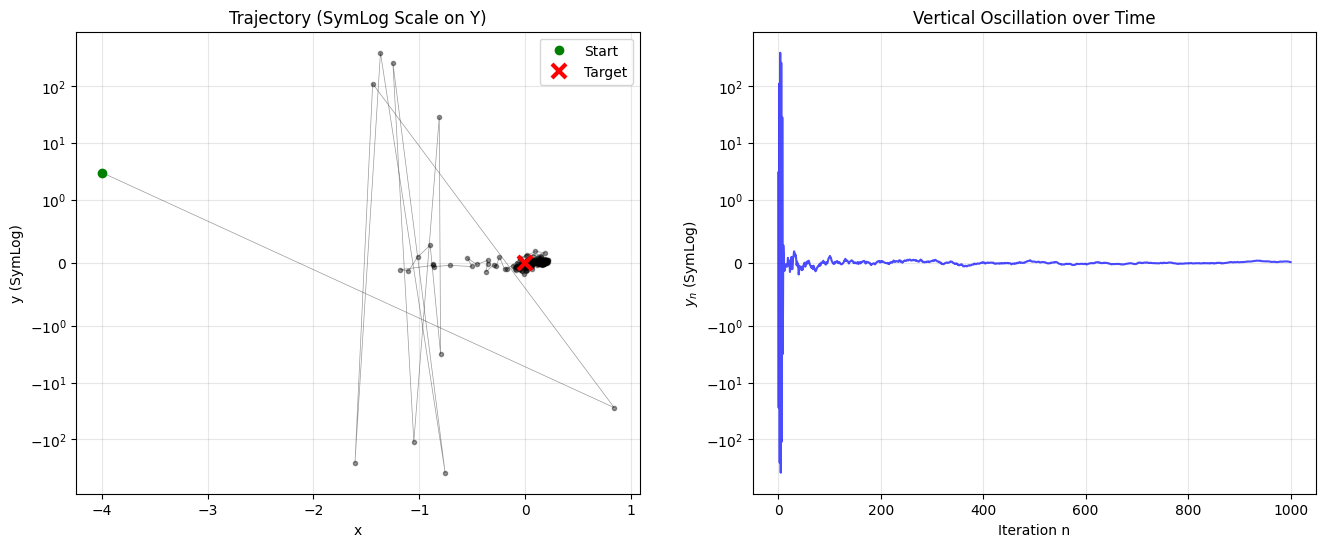

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Run the "Unstable" case (gamma = 1/n)
def true_negative_gradient(X):
    return -np.array([X[0], 10 * X[1]])

def get_noisy_observation(X):
    return true_negative_gradient(X) + np.random.normal(0, 2.0, size=2)

X = np.array([-4.0, 3.0])
history = [X.copy()]
N = 1000

for n in range(1, N + 1):
    gamma_n = 1.0 / n  # Large initial step size
    X = X + gamma_n * get_noisy_observation(X)
    history.append(X.copy())

history = np.array(history)

# Plot with SymLog
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Trajectory (y vs x)
ax1.plot(history[:, 0], history[:, 1], 'k.-', alpha=0.4, linewidth=0.5)
ax1.plot(history[0, 0], history[0, 1], 'go', label='Start')
ax1.plot(0, 0, 'rx', markersize=10, markeredgewidth=3, label='Target')

# SymLog scale
ax1.set_yscale('symlog', linthresh=1.0) 

ax1.set_title('Trajectory (SymLog Scale on Y)')
ax1.set_xlabel('x')
ax1.set_ylabel('y (SymLog)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: y-value vs iteration
ax2.plot(history[:, 1], 'b-', alpha=0.7)
ax2.set_yscale('symlog', linthresh=1.0)
ax2.set_title('Vertical Oscillation over Time')
ax2.set_xlabel('Iteration n')
ax2.set_ylabel(r'$y_n$ (SymLog)')
ax2.grid(True, which='both', alpha=0.3)

plt.show()

<br>
<br>
<br>
<br>
<br>

## Part II: Reinforcement Learning

In the previous parts, we solved the MDP using **Dynamic Programming** (Bellman (Functional) Equations, Value Iteration, Policy Iteration). These methods require full knowledge of the environment's dynamics:
* the transition probabilities $P(s'|s, a)$
* the reward function $r(s, a)$

**Reinforcement Learning (RL)** addresses the problem where **the agent does not know the model** ($P$ and $r$). The agent must learn the value functions and optimal policies (and possibly the transition model in model-based RL) solely by interacting with the environment (collecting samples of transitions $(s, a, r, s')$, where $r$ is called the *reinforcement signal*).

Before jumping into RL algorithms based on the Stochastic Approximation theory studied above, the Reinforcement Learning approach based on the law of large numbers is presented first. This approach is called **Monte Carlo Reinforcement Learning** since it relies on the approximation of expectations by empirical averages over sampled trajectories (which is at the core of Monte Carlo methods).

<br>

### Monte Carlo Reinforcement Learning



The simplest Reinforcement Learning algorithm is the **Monte Carlo Policy Iteration Algorithm**.
This algorithm is obtained by replacing the model-based policy evaluation step in the policy iteration algorithm with a **model-free Monte Carlo (MC) estimation step**. (The name "Monte Carlo" refers to the randomness in casino gambling).

### Definition (Monte Carlo Policy Iteration Algorithm):

Define the **state-action value function** (or Q-function) associated with policy $\pi$ as:
$$
q^\pi_\gamma(s, a) = \mathbb{E}^\pi \left[ \sum_{t=0}^{\infty} \gamma^t r(X_t, Y_t) \mid X_0 = s, Y_0 = a \right], \quad \forall s \in S, a \in A
$$
Using the definition of $q^\pi_\gamma$, the policy improvement at step $n$ is defined as
$$
\pi_{n+1}(s) \in \arg\max_{a \in A} q^{\pi_n}_\gamma(s, a), \quad \forall s \in S
$$
Moreover, the state-action value function $q^\pi_\gamma$ can be estimated using sampled episodes generated by following policy $\pi$ in the environment.
In other words,
$$
\hat{q}^\pi_\gamma(s, a) = \frac{1}{N(s, a)} \sum_{i=1}^{N(s, a)} \sum_{t=0}^{\infty} \gamma^t r(X_t^{(i)}, Y_t^{(i)})
$$
where $N(s, a)$ is the number of times action $a$ has been taken in state $s$ in the sampled episodes, and $(X_t^{(i)}, Y_t^{(i)})$ are the states and actions observed in the $i$-th episode with $X_0^{(i)} = s$ and $Y_0^{(i)} = a$.
Of course,
$$
\mathbb{E}[\hat{q}^\pi_\gamma(s, a)] = q^\pi_\gamma(s, a)
$$
The estimator is unbiased. However, it may have high variance and is know to be inefficient in practice.

The **Monte Carlo Policy Iteration Algorithm** is defined as follows:
- Initialise a stationary deterministic Markovian policy $\pi_0 = d_0$, set $n = 0$.
- Repeat until convergence (i.e., until $\pi_{n+1} = \pi_n$):
    - **Monte Carlo Policy Evaluation Step**: Estimate the state-action value function $q^{\pi_n}_\gamma$ corresponding to policy $\pi_n$ using sampled episodes generated by following policy $\pi_n$ in the environment.
    - **Policy Improvement Step**: Update the policy by setting, for all states $s \in S$,
    $$
    \pi_{n+1}(s) \in \arg\max_{a \in A} \hat{q}^{\pi_n}_\gamma(s, a)
    $$
    - Increment $n$ by 1.

<div class="alert alert-warning">

#### Question: Monte Carlo Policy Evaluation

Consider the inventory management MDP defined previously.
We wish to estimate the value function $v^\pi$ of a specific **heuristic policy** $\pi$ without knowing the model probabilities, using only interaction with the environment.

Consider the following policy $\pi$:
* If stock $s=0$: Order to fill the warehouse (action $a = M$).
* If stock $s > 0$: Do not order (action $a = 0$).

Consider the other policy $\pi'$:
* If stock $s < M$: Order to fill the warehouse (action $a = M$).
* If stock $s = M$: Do not order (action $a = 0$).

Implement the Monte Carlo Policy Evaluation Step of the algorithm to estimate the value function $v^\pi$ of these policy.
* Compare the estimated values with respect to the number of steps used in the simulation.


</div>

<div class="alert alert-info">

#### Answer:

To solve this, we will simulate the inventory environment. Since Monte Carlo estimation relies on the law of large numbers, the accuracy of our value estimation depends on the size of the sample.

For this implementation, the order cost function which is part of the reward function is equal to $O(a) = 1 + a$ for $a \geq 0$ and 0 otherwise.

We will:
1.  **Define the environment:** Transition dynamics (demand) and reward function (costs/revenue).
    * *Note: Arbitrary but reasonable cost parameters are chosen below to make the simulation runnable (Capacity $M=3$, $\gamma=0.9$).*
2.  **Define the policy:** The specific heuristic described.
3.  **Implement Monte-Carlo evaluation:** Run simulations for each state to compute the average discounted return.
4.  **Compare convergence:** Run the evaluation with increasing numbers of episodes to observe how the value estimates stabilise.

</div>

```
Estimated Value Function (N=1000):
State |   Lazy  | Proactive
  0   |  38.49  |  30.68
  1   |  40.07  |  31.08
  2   |  42.30  |  32.43
  3   |  42.05  |  34.41
  ```

### Stochastic Approximation for Policy Evaluation

One essential result in Dynamic Programming is that value functions (being optimal or not) are unique fixed points of some Bellman operator ($\mathcal{T}_\gamma^\pi$ for policy evaluation and $\mathcal{T}_\gamma^*$ for optimality).
In other words, for any policy $\pi$, its value function $v^\pi$ satisfies:
$$
v^\pi - \mathcal{T}_\gamma^\pi v^\pi = 0
$$
$$
q^\pi - \mathcal{T}_\gamma^\pi q^\pi = 0
$$
and for the optimal value function $v^*$:
$$
v^* - \mathcal{T}_\gamma^* v^* = 0
$$
$$
q^* - \mathcal{T}_\gamma^* q^* = 0
$$

where, for the value functions, the operators $\mathcal{T}_\gamma^\pi$ and $\mathcal{T}_\gamma^*$ are defined as:
$$
\mathcal{T}_\gamma^\pi v(s) = r(s, \pi(s)) + \gamma \mathbb{E}_{s' \sim P(\cdot | s, \pi(s))}[v(s')]
$$
$$
\mathcal{T}_\gamma^* v(s) = \max_{a \in A} \left( r(s, a) + \gamma \mathbb{E}_{s' \sim P(\cdot | s, a)}[v(s')] \right)
$$
and similarly for the Q-functions:
$$
\mathcal{T}_\gamma^\pi q(s, a) = r(s, a) + \gamma \mathbb{E}_{s' \sim P(\cdot | s, a)}[q(s', \pi(s'))]
$$
$$
\mathcal{T}_\gamma^* q(s, a) = r(s, a) + \gamma \mathbb{E}_{s' \sim P(\cdot | s, a)}\left[ \max_{a' \in A} q(s', a') \right]
$$

This reduces the problem of finding the zero of a operator (acting on functions) to solving the Bellman equations. In particular, the operator equations should be satisfied for any state $s$ and action $a$ (when considering Q-functions), for example: $q^\pi (s, a) - \mathcal{T}_\gamma^\pi q^\pi(s, a) = 0$ for all $s$ and $a$. Thus, for all states $s$ and actions $a$, a zero of the equation is required to find the state-action value function $q^\pi$ (in the $\mathcal{T}_\gamma^\pi$ case) or the optimal state-action value function $q^*$ (in the $\mathcal{T}_\gamma^*$ case).


This observation allows us to use **Stochastic Approximation** methods to solve these equations when the model is unknown, by collecting samples of transitions $(s, a, r, s')$ and using them to estimate the expectations in the Bellman operators.

Specifically,
$$
r(s, a) + \gamma \mathbb{E}_{s' \sim P(\cdot | s, a)}[q(s', \pi(s'))] - q(s, a) = 0
$$
This can be expressed as an expectation over the transition to the next state $S'$ given the current state $s$ and action $a$:
$$
\mathbb{E}_{S' \sim P(\cdot | s, a)} \left[ r(s, a) + \gamma q(S', \pi(S')) - q(s, a) \right] = 0
$$
Here, the term inside the expectation, $\delta = r(s, a) + \gamma q(S', \pi(S')) - q(s, a)$, represents a **noisy sample** of the function we want to zero out. This fits perfectly into the **Robbins-Monro** framework.

##### --- TD-Learning, SARSA, and Q-Learning via Robbins-Monro ---

We can map the components of the Robbins-Monro theorem to our Reinforcement Learning context to derive the standard algorithms:

1.  **The unknown parameter ($X_n \to Q_n$):**
    In Robbins-Monro, we update an estimate $X_n$ to find a root. In RL, our unknown parameter is the Q-value for a specific state-action pair, so $X_n$ corresponds to our current estimate $Q_n(s, a)$.

2.  **The noisy observation ($Y_{n+1}$):**

    The theorem requires a noisy observation $Y_{n+1}$ whose expected value is the function we want to zero.
    In RL, the noisy observation corresponding to one sample transition $(s, a, r, s')$ is the **Temporal Difference (TD) error**:
    $$
    Y_{n+1} = \delta_n = \underbrace{r + \gamma \text{Target}}_{\text{Bootstrap Target}} - Q_n(s, a)
    $$
    * **SARSA:** Target is $Q_n(s', a')$, where $a'$ is the action taken in state $s'$ according to the current policy (**On-Policy**).
    * **Q-Learning:** Target is $\max_{a'} Q_n(s', a')$, the optimal future value. This can also be seen as the target being $Q_n(s', \pi^{G}(s'))$ where $\pi^{G}$ is the greedy policy w.r.t. $Q_n$ (**Off-Policy**).

    * **TD(0):** in this case the estimate is for the state-value function $V_n(s)$, and the target is $\gamma V_n(s')$:
    $$
    Y_{n+1} = \delta_n = r + \gamma V_n(s') - V_n(s)
    $$


3.  **The update rule ($X_{n+1} = X_n + \gamma_n Y_{n+1}$):**

    Applying the Robbins-Monro update rule directly gives us the standard RL update formulas, where the step size sequence $\gamma_n$ corresponds to the learning rate $\alpha_n$.

    * **SARSA Update:**
        $$Q(s, a) \leftarrow Q(s, a) + \alpha [ r + \gamma Q(s', a') - Q(s, a) ]$$
    * **Q-Learning Update:**
        $$Q(s, a) \leftarrow Q(s, a) + \alpha [ r + \gamma \max_{b} Q(s', b) - Q(s, a) ]$$

4.  **Convergence conditions:**

    **Informal Theorem (Q-Learning, SARSA, TD(0) Convergence):**

    The Robbins-Monro theorem guarantees almost sure convergence ($Q_n \xrightarrow{a.s.} q^*$) provided:
    * **Step sizes:** The learning rates satisfy $\sum \alpha_n = \infty$ and $\sum \alpha_n^2 < \infty$.
    * **Exploration:** All state-action pairs must be visited infinitely often.

<div class="alert alert-warning">

#### Question: TD Learning (Policy Evaluation)


Implement the **TD Learning** algorithm to estimate $v^\pi(s)$.
* Run the simulation for a large number of steps.
* Use a learning rate $\alpha$ that decays over time. A common choice for convergence is $\alpha_t(s) = 1 / N(s)$, where $N(s)$ is the number of times state $s$ has been visited.
* Initialize $V(s) = 0$ for all $s$.
* Compare the estimation with the true value function obtained by Dynamic Programming.


</div>

<div class="alert alert-info">

#### Answer:


Code cell below for TD(0).
For this implementation, the order cost function which is part of the reward function is equal to $O(a) = 1 + a$ for $a \geq 0$ and 0 otherwise.


</div>

##### Evaluation of three different policies and comparison

In this section, we will solve the **Stochastic Inventory Control Problem** over a infinite horizon.

The ordering costs chosen in this study are:
* **Fixed cost** : 1 for each order placed (reduced from 4)
* **Marginal cost** $c$ : 1 per unit (reduced from 2)

We will compare three different strategies (policies):

1.  *Optimal Policy* ($\pi^*$): The policy derived from policy iteration.
2.  *Lazy Policy* ($\pi_{lazy}$): A simple heuristic where we only order more stock if the warehouse is completely empty ($s=0$). If we order, we fill it to capacity ($M$).
3.  *Proactive Policy* ($\pi_{pro}$): A heuristic where we *always* order enough to fill the warehouse to capacity ($M$) at every step, regardless of the current stock.

**Goal:**
Compute the **value function** $v^\pi(s)$ (expected total reward from $t=0$) for each of these three policies and compare them.

```
Optimal Policy: [2 0 0 0]

Value Functions (Expected Discounted Reward):
State  | Optimal  | Lazy     | Proactive 
----------------------------------------
0      | 41.62    | 38.59    | 30.25     
1      | 42.70    | 40.06    | 31.25     
2      | 44.62    | 42.21    | 32.25     
3      | 44.75    | 42.59    | 34.25     
```

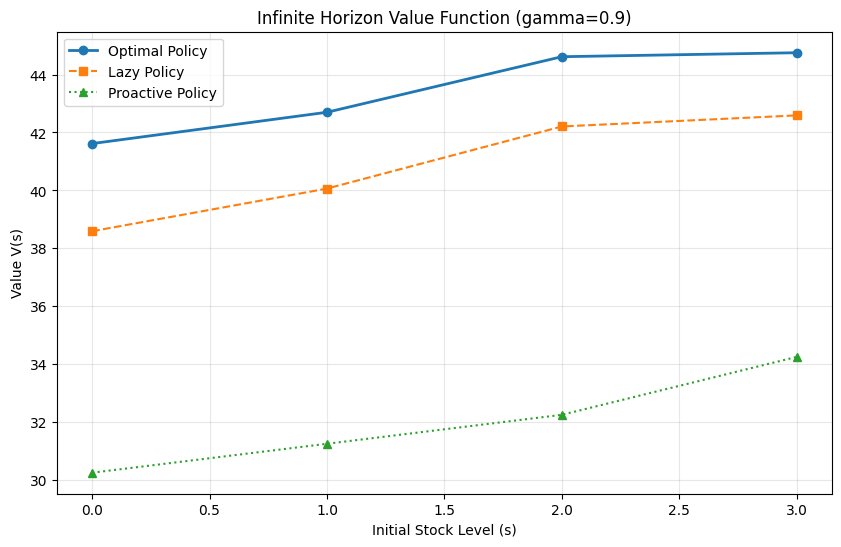

In [7]:
# --- Visualization ---
states = np.arange(M + 1)
plt.figure(figsize=(10, 6))
plt.plot(states, V_opt, 'o-', label='Optimal Policy', linewidth=2)
plt.plot(states, V_lazy, 's--', label='Lazy Policy')
plt.plot(states, V_pro, '^:', label='Proactive Policy')
plt.title(f'Infinite Horizon Value Function (gamma={gamma})')
plt.xlabel('Initial Stock Level (s)')
plt.ylabel('Value V(s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

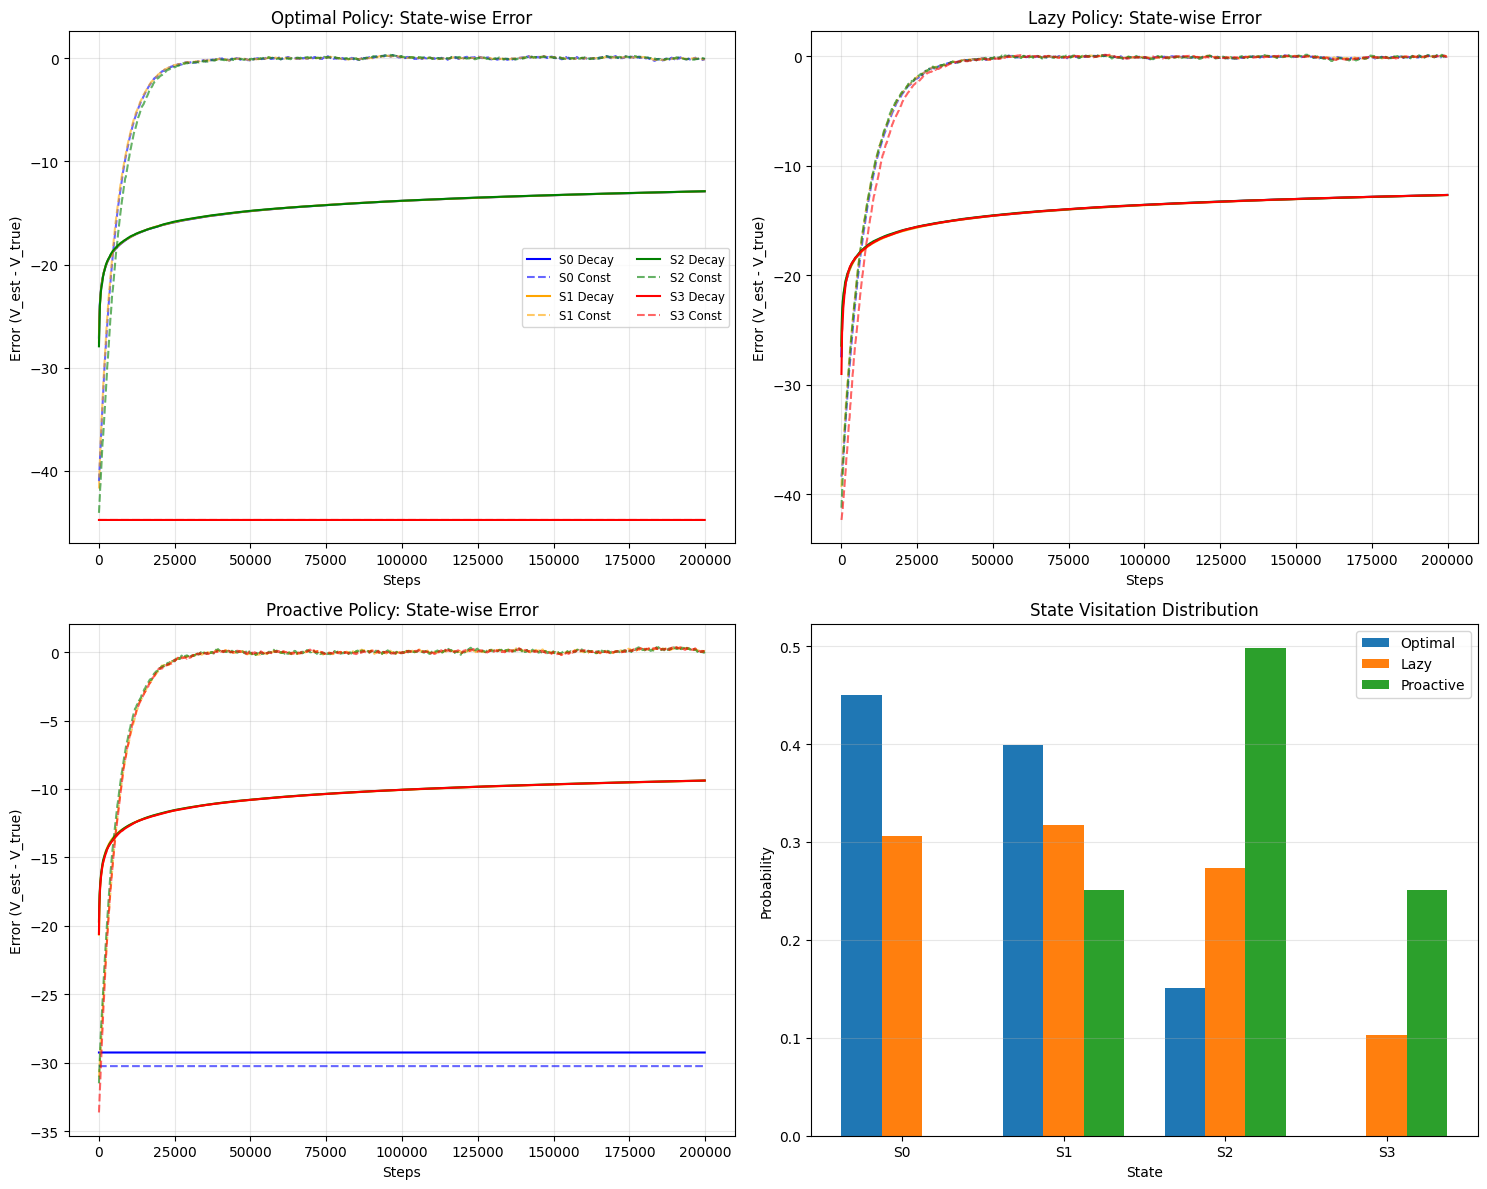

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
ax_list = axes.flatten()

# Colors for states
state_colors = ['blue', 'orange', 'green', 'red']

# Visitation data container
all_visits = {}

for i, p in enumerate(policies):
    # Run Decay
    errors_decay, visits_decay = run_td_state_tracking(p, V_true_dict[p], n_steps, 'decay')
    # Run Constant
    errors_const, _ = run_td_state_tracking(p, V_true_dict[p], n_steps, 'constant', constant_learning_rate)
    
    # Store visits for the 4th plot
    all_visits[p] = visits_decay

    # Plot State-wise Errors
    ax = ax_list[i]
    steps = np.arange(0, n_steps, 100)
    
    for s in range(M + 1):
        # Solid line for Decay
        ax.plot(steps, errors_decay[:, s], label=f'S{s} Decay', color=state_colors[s], linestyle='-')
        # Dashed line for Constant (lighter alpha to distinguish overlap)
        ax.plot(steps, errors_const[:, s], label=f'S{s} Const', color=state_colors[s], linestyle='--', alpha=0.6)
        
    ax.set_title(f'{p} Policy: State-wise Error')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Error (V_est - V_true)')
    ax.grid(True, alpha=0.3)
    
    # Only add legend to one plot to avoid clutter, or simplify it
    if i == 0:
        ax.legend(ncol=2, fontsize='small')

# Plot 4: Visitation Distribution
ax_vis = ax_list[3]
x = np.arange(M + 1)
width = 0.25
for i, p in enumerate(policies):
    # Normalize to probability
    probs = all_visits[p] / np.sum(all_visits[p])
    ax_vis.bar(x + i*width, probs, width, label=p)

ax_vis.set_title('State Visitation Distribution')
ax_vis.set_xlabel('State')
ax_vis.set_ylabel('Probability')
ax_vis.set_xticks(x + width)
ax_vis.set_xticklabels([f'S{s}' for s in x])
ax_vis.legend()
ax_vis.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


**Remarks:** Since the Temporal Difference (TD) learning algorithm is applied by following a unique trajectory, some states are not visited, depending on the policy choice. The histogram of visited states is plotted to illustrate this phenomenon.

<div class="alert alert-warning">

#### Question: SARSA (On-Policy Control)

By default, SARSA is an **on-policy** algorithm, meaning it estimates the value of the policy being followed. However, if the fixed policy does not allow for visiting all state-action pairs, the convergence conditions of the Robbins-Monro theorem are not satisfied. In this case, the exploration property of the policy is not sufficient to guarantee convergence.

- Implement the **SARSA** algorithm for policy evaluation.
- Compare the results with the Monte Carlo policy evaluation implemented previously.

One way to ensure all state-action pairs are visited infinitely often is to use an $\epsilon$-greedy policy during learning. This means that with probability $\epsilon \in [0, 1]$, a random action is chosen, and with probability $1-\epsilon$, the greedy action according to the current Q-values is selected.

<br>


Moreover, it is also possible to use SARSA for control.
In this case, the policy is not stationary: it is $\epsilon$-greedy w.r.t. the current Q-values, which are updated at each step where $\epsilon$ decays over time to ensure convergence to the greedy policy.
One can show that under these conditions, SARSA converges to the optimal Q-function.

Implement the **SARSA** algorithm to find the optimal policy.

* Use an $\epsilon$-greedy exploration strategy:
    * With probability $\epsilon$, choose a random valid action.
    * With probability $1-\epsilon$, choose the greedy action $a = \arg\max_a Q(s, a)$.
* Run the training for a large number of steps.
* Try running with a fixed $\epsilon = 0.1$.
* Optional: Compare the learned Q-values with an execution where $\epsilon$ decays to 0 (e.g., $\epsilon = 1/\sqrt{C n_{steps}}$).

</div>

<div class="alert alert-info">

#### Answer:

Code cell below for SARSA.
For this implementation, the order cost function which is part of the reward function is equal to $O(a) = 1 + a$ for $a \geq 0$ and 0 otherwise.

</div>

```
Q* Table:
[[37.46 40.7  41.62 40.75]
 [42.7  42.62 41.75  -inf]
 [44.62 42.75  -inf  -inf]
 [44.75  -inf  -inf  -inf]]
Running SARSA with epsilon=0.0...
Running SARSA with epsilon=0.1...
Running SARSA with epsilon=0.5...
Running SARSA with decaying epsilon...
```

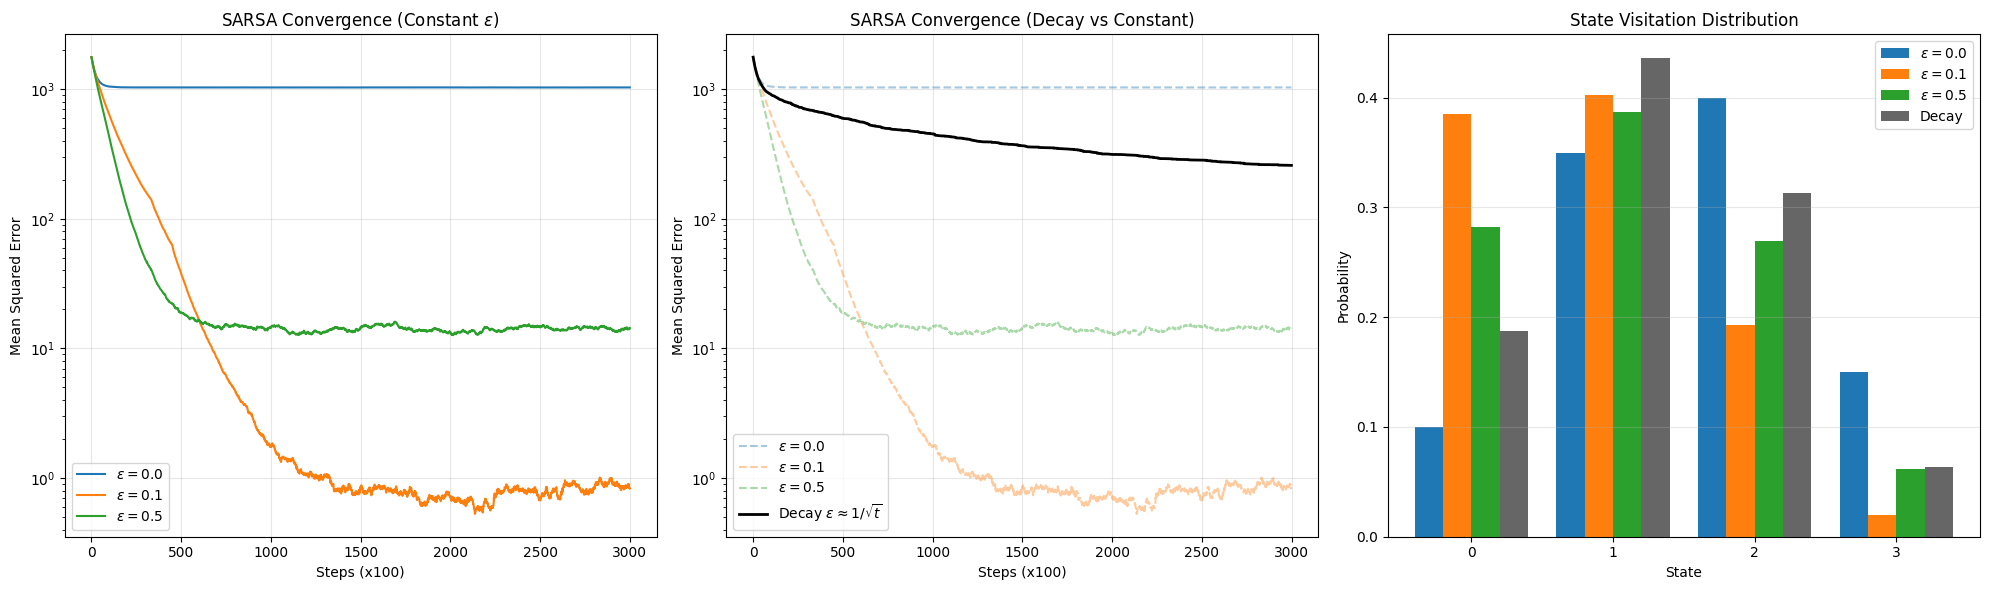


--- Final Learned Policies ---
Epsilon 0.0: [3, 2, 0, 0]
Epsilon 0.1: [2, 1, 0, 0]
Epsilon 0.5: [2, 1, 0, 0]
Epsilon Decay: [3, 1, 0, 0]


In [ ]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: MSE for Constant Epsilons
ax1 = axes[0]
for eps in epsilons:
    ax1.plot(results[eps]['mse'], label=f'$\epsilon={eps}$')
ax1.set_title(r'SARSA Convergence (Constant $\epsilon$)')
ax1.set_xlabel('Steps (x100)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: MSE Comparison (Best Constant vs Decay)
ax2 = axes[1]
# Plot the best constant epsilon (usually 0.1 or 0.0 depending on exploration needs)
# We plot all constants faintly, and decay boldly
for eps in epsilons:
    ax2.plot(results[eps]['mse'], label=f'$\epsilon={eps}$', alpha=0.4, linestyle='--')
ax2.plot(mse_decay, label=r'Decay $\epsilon \approx 1/\sqrt{t}$', color='black', linewidth=2)

ax2.set_title(r'SARSA Convergence (Decay vs Constant)')
ax2.set_xlabel('Steps (x100)')
ax2.set_ylabel('Mean Squared Error')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Visitation Distribution
ax3 = axes[2]
x = np.arange(M + 1)
width = 0.2
# Plot constants
for i, eps in enumerate(epsilons):
    probs = results[eps]['visits'] / np.sum(results[eps]['visits'])
    ax3.bar(x + (i-1.5)*width, probs, width, label=f'$\epsilon={eps}$')
# Plot decay
probs_decay = visits_decay / np.sum(visits_decay)
ax3.bar(x + (len(epsilons)-1.5)*width, probs_decay, width, label='Decay', color='black', alpha=0.6)

ax3.set_title('State Visitation Distribution')
ax3.set_xlabel('State')
ax3.set_ylabel('Probability')
ax3.set_xticks(x)
ax3.legend()
ax3.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print Final Policies
print("\n--- Final Learned Policies ---")
for eps in epsilons:
    q = results[eps]['Q']
    policy = []
    for s in range(M+1):
        valid = [a for a in range(M+1) if s+a<=M]
        best_a = valid[np.argmax(q[s, valid])]
        policy.append(best_a)
    print(f"Epsilon {eps}: {policy}")

q = q_decay
policy = []
for s in range(M+1):
    valid = [a for a in range(M+1) if s+a<=M]
    best_a = valid[np.argmax(q[s, valid])]
    policy.append(best_a)
print(f"Epsilon Decay: {policy}")

**Remarks:** The best performances are obtained with the intermediate exploration policy (fixed $\epsilon = 0.1$). That is the only one that is able to learn the *optimal policy*.

<div class="alert alert-warning">

#### Question: Q-Learning (Off-Policy Control)

Implement the **Q-Learning** algorithm.
Unlike SARSA, Q-Learning is **off-policy**: it updates the Q-values with a policy that is **not necessarily the policy used to interact with the environment (to generate the data, sometimes called the behavior policy)**, i.e. by following the greedy policy w.r.t. the current Q-values ($\max_a Q(s', a) = Q(s', \pi^{G}(s))$, where $\pi^{G}$ is the greedy policy).

Thus, off-policy algorithms use two different policies:
* The **behavior policy**: the policy used to generate data (to interact with the environment). This policy should ensure sufficient exploration of the state-action space (to ensure convergence).
* The **target policy**: the policy used to compute the target values for the Q-value updates. This policy is often the greedy policy when possible.


Now, implement the **Q-Learning** algorithm to find the optimal policy.


* Use $\epsilon$-greedy for behavior (to explore), but use the $\max$ operator for the target update.
* Compare the convergence of Q-Learning vs SARSA.
* Compare your results with the solution obtained by Dynamic Programming.

</div>

<div class="alert alert-info">

#### Answer:

Code cell below for Q-Learning.
For this implementation, the order cost function which is part of the reward function is equal to $O(a) = 1 + a$ for $a \geq 0$ and 0 otherwise.

</div>

```
Running Q-Learning with epsilon=0.0...
Running Q-Learning with epsilon=0.1...
Running Q-Learning with epsilon=0.5...
```

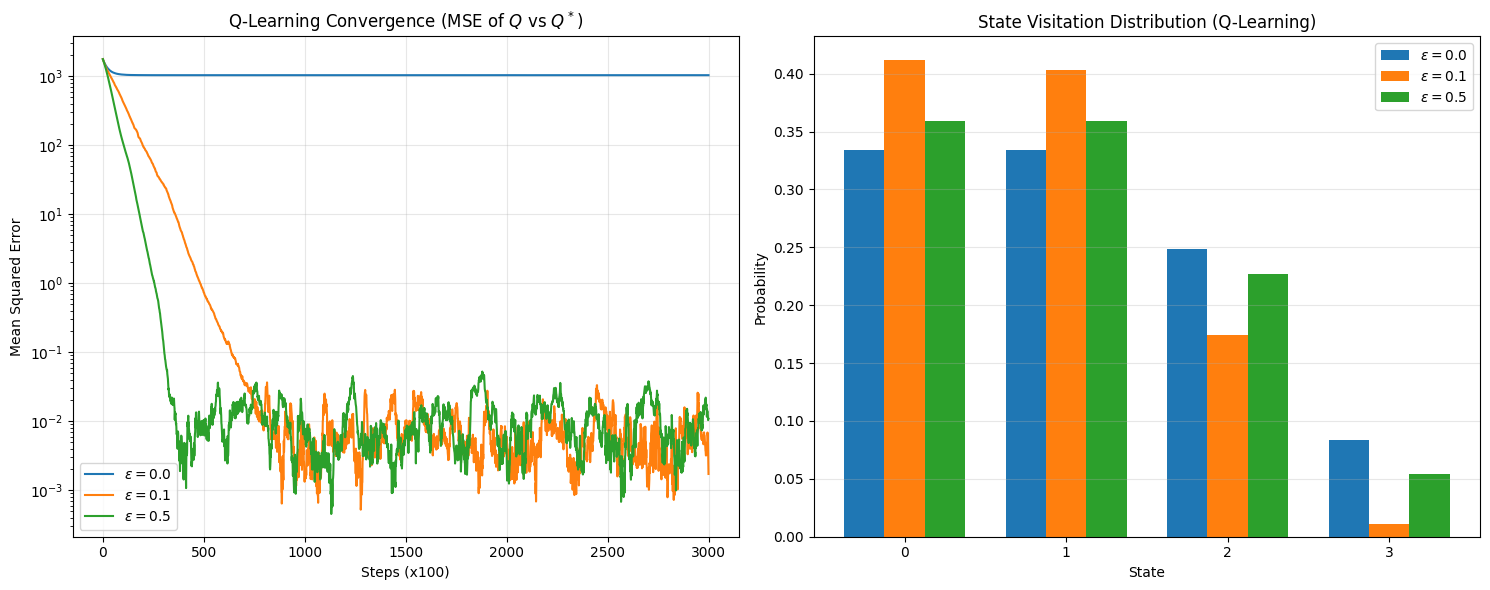


--- Final Learned Policies (Q-Learning) ---
Epsilon 0.0: [2, 0, 1, 0]
Epsilon 0.1: [2, 0, 0, 0]
Epsilon 0.5: [2, 0, 0, 0]


In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# MSE Plot
ax1 = axes[0]
for eps in epsilons:
    ax1.plot(results_q[eps]['mse'], label=f'$\epsilon={eps}$')
ax1.set_title(r'Q-Learning Convergence (MSE of $Q$ vs $Q^*$)')
ax1.set_xlabel('Steps (x100)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Visitation Plot
ax2 = axes[1]
x = np.arange(M + 1)
width = 0.25
for i, eps in enumerate(epsilons):
    probs = results_q[eps]['visits'] / np.sum(results_q[eps]['visits'])
    ax2.bar(x + (i-1)*width, probs, width, label=f'$\epsilon={eps}$')
ax2.set_title('State Visitation Distribution (Q-Learning)')
ax2.set_xlabel('State')
ax2.set_ylabel('Probability')
ax2.set_xticks(x)
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print Final Policies
print("\n--- Final Learned Policies (Q-Learning) ---")
for eps in epsilons:
    q = results_q[eps]['Q']
    policy = []
    for s in range(M+1):
        valid = [a for a in range(M+1) if s+a<=M]
        best_a = valid[np.argmax(q[s, valid])]
        policy.append(best_a)
    print(f"Epsilon {eps}: {policy}")

**Remarks:** Here, Q-learning learns the optimal policy for any exploration strategy with $\epsilon > 0$.

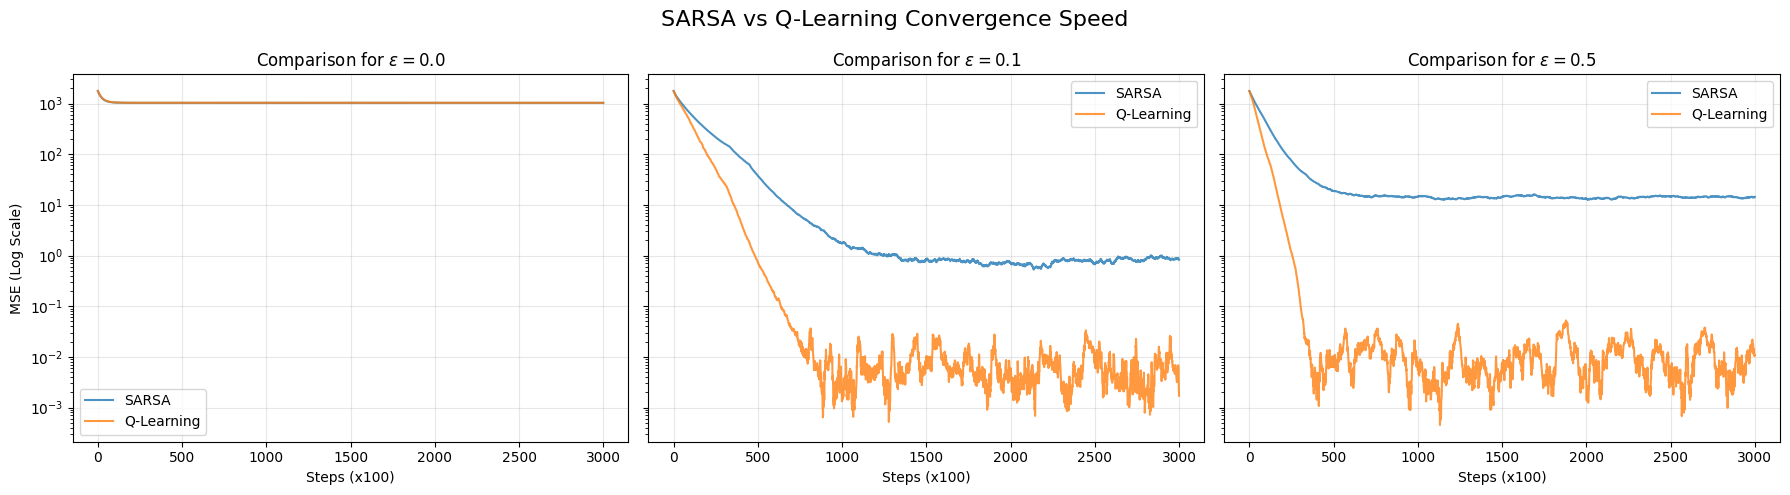

In [ ]:
# Use sharey=True to ensure all subplots have the same Y-axis scale
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, eps in enumerate(epsilons):
    ax = axes[i]
    
    # Plot SARSA
    if 'results' in globals() and eps in results:
        ax.plot(results[eps]['mse'], label='SARSA', alpha=0.8)
    
    # Plot Q-Learning
    if 'results_q' in globals() and eps in results_q:
        ax.plot(results_q[eps]['mse'], label='Q-Learning', alpha=0.8)
    
    ax.set_title(f'Comparison for $\epsilon={eps}$')
    ax.set_xlabel('Steps (x100)')
    
    if i == 0:
        ax.set_ylabel('MSE (Log Scale)')
        
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('SARSA vs Q-Learning Convergence Speed', fontsize=16)
plt.tight_layout()
plt.show()